In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import seaborn as sns
from sklearn import model_selection, preprocessing
#import xgboost as xgb
color = sns.color_palette()

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [ ]:
import os
os.getcwd()

In [3]:
train = pd.read_csv('train.csv')

In [4]:
test = pd.read_csv('test.csv')

In [ ]:
train.head()

In [ ]:
train.shape

In [ ]:
test.shape

In [5]:
trainy = train.price_doc

In [ ]:
train.shape

In [ ]:
trainy.head()

## Missing values - ( Let Xgboost handle)

In [ ]:
(train.isnull().sum().sort_values(ascending = False).head(20)/train.shape[0]).plot(kind="bar")

- We can drop some of the columns that have above 30% missing values except for build_year, state, max_floor, material, num_room, kitch_sq. These attributes seem to be important.


In [ ]:
(train.isnull().sum().sort_values(ascending = False).head(20)/train.shape[0])

In [6]:
train.drop(['hospital_beds_raion','cafe_avg_price_500','cafe_sum_500_max_price_avg','cafe_sum_500_min_price_avg'], axis=1, inplace = True)

In [7]:
test.drop(['hospital_beds_raion','cafe_avg_price_500','cafe_sum_500_max_price_avg','cafe_sum_500_min_price_avg'], axis=1, inplace = True)

In [8]:
train = train.drop(["id", "timestamp","price_doc"], axis=1)
test = test.drop(["id", "timestamp"], axis=1)

In [ ]:
train.isnull().sum().sum()

In [9]:
trainy.shape

(30471,)

### Imputing mean values for numeric columns and the most frequent value for non-numeric columns 

In [32]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [33]:
train = DataFrameImputer().fit_transform(train)

In [34]:
test = DataFrameImputer().fit_transform(test)

### Label encoding for all attributes that are of categorical type

In [10]:
from sklearn.preprocessing import LabelEncoder

for c in train.columns:
    if train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in test.columns:
    if test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(test[c].values)) 
        test[c] = lbl.transform(list(test[c].values))
        #x_test.drop(c,axis=1,inplace=True) 



In [ ]:
train.head()

### Standardize the data

In [ ]:
from sklearn.preprocessing import StandardScaler
train_std = StandardScaler().fit_transform(train)
test_std = StandardScaler().fit_transform(test)


## Remove multicollinear variables

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [ ]:
transformer = ReduceVIF()

# Only use 10 columns for speed in this example
X = transformer.fit_transform(X[X.columns], y)

X.head()

In [ ]:
#labels = np.array(['cafe_count_1500','cafe_count_2000','cafe_count_3000','cafe_count_5000','cafe_avg_price_5000','cafe_avg_price_3000','cafe_avg_price_2000','cafe_avg_price_1500','cafe_sum_5000_max_price_avg','cafe_sum_3000_max_price_avg','cafe_sum_2000_max_price_avg','cafe_count_5000_price_1000','cafe_sum_1500_max_price_avg','cafe_count_3000_price_1500','cafe_count_5000_price_2500','cafe_count_3000_price_500','cafe_count_5000_price_1500','office_count_5000','cafe_count_3000_price_2500','office_count_3000','cafe_count_2000_price_1500','cafe_count_2000_price_2500','cafe_count_2000_price_500','office_count_2000','cafe_count_3000_price_1000','church_count_3000','cafe_count_5000_price_500','cafe_count_2000_price_1000','church_count_2000','cafe_count_1500_price_4000','cafe_count_5000_na_price','church_count_5000','cafe_count_3000_price_4000','cafe_count_1500_price_1500','big_church_count_2000','cafe_count_5000_price_4000','cafe_count_1500_price_500','cafe_count_2000_na_price','cafe_count_1500_price_2500','big_church_count_3000','green_part_2000','church_count_1500','leisure_count_3000','cafe_count_2000_price_4000','cafe_count_3000_na_price','leisure_count_5000','trc_count_5000','leisure_count_2000','sport_count_3000','cafe_count_1500_price_1000','big_church_count_1500','prom_part_2000','office_sqm_3000','cafe_count_2000_price_high','green_part_3000','office_count_1500','cafe_sum_5000_min_price_avg','trc_count_2000','sport_count_5000','cafe_sum_2000_min_price_avg','sport_count_2000','church_count_1000','cafe_count_3000_price_high','trc_count_3000','office_sqm_5000','prom_part_5000','leisure_count_1500','office_sqm_2000','cafe_count_1500_na_price','cafe_count_1000_price_4000','cafe_sum_1500_min_price_avg','trc_sqm_5000','sport_count_1500','big_church_count_5000','cafe_count_1500_price_high','market_count_2000','market_count_5000','cafe_sum_3000_min_price_avg','trc_sqm_2000','trc_count_1500','cafe_count_5000_price_high','prom_part_3000','big_church_count_1000','green_part_5000'])

#X = train.drop(labels,axis=1)

In [ ]:
#X.shape

# Remove near zero variance variables

In [29]:
import itertools
from sklearn.feature_selection import VarianceThreshold

def remove_feat_constants(data_frame):
    # from https://www.kaggle.com/tuomastik/santander-customer-satisfaction/pca-visualization
    # script by Tuomas Tikkanen
    # Remove feature vectors containing one unique value,
    # because such features do not have predictive value.
    # Let's get the zero variance features by fitting VarianceThreshold
    # selector to the data, but let's not transform the data with
    # the selector because it will also transform our Pandas data frame into
    # NumPy array and we would like to keep the Pandas data frame. Therefore,
    # let's delete the zero variance features manually.
    n_features_originally = data_frame.shape[1]
    selector = VarianceThreshold(0.1) # giving 0.1 meaning less than 10% variance then drop
    selector.fit(data_frame)
    # Get the indices of zero variance feats
    feat_ix_keep = selector.get_support(indices=True)
    orig_feat_ix = np.arange(data_frame.columns.size)
    feat_ix_delete = np.delete(orig_feat_ix, feat_ix_keep)
    # Delete zero variance feats from the original pandas data frame
    data_frame = data_frame.drop(labels=data_frame.columns[feat_ix_delete],
                                 axis=1)
    # Print info
    print(data_frame.columns[feat_ix_delete])
    n_features_deleted = feat_ix_delete.size
    print("  - Deleted %s / %s features (~= %.1f %%)" % (
        n_features_deleted, n_features_originally,
        100.0 * (np.float(n_features_deleted) / n_features_originally)))
    return data_frame

### Removing identical features

In [30]:
def remove_feat_identicals(data_frame):
    # from https://www.kaggle.com/tuomastik/santander-customer-satisfaction/pca-visualization
    # script by Tuomas Tikkanen
    # Find feature vectors having the same values in the same order and
    # remove all but one of those redundant features.
    n_features_originally = data_frame.shape[1]
    # Find the names of identical features by going through all the
    # combinations of features (each pair is compared only once).
    feat_names_delete = []
    for feat_1, feat_2 in itertools.combinations(
            iterable=data_frame.columns, r=2):
        if np.array_equal(data_frame[feat_1], data_frame[feat_2]):
            feat_names_delete.append(feat_2)
    feat_names_delete = np.unique(feat_names_delete)
    # Delete the identical features
    data_frame = data_frame.drop(labels=feat_names_delete, axis=1)
    n_features_deleted = len(feat_names_delete)
    print(feat_names_delete)
    print("  - Deleted %s / %s features (~= %.1f %%)" % (
        n_features_deleted, n_features_originally,
        100.0 * (np.float(n_features_deleted) / n_features_originally)))
    return data_frame
 

In [35]:
train = remove_feat_constants(train)

Index(['children_preschool', 'preschool_quota', 'office_raion', 'female_f',
       'young_all', 'young_male', 'work_all', 'work_male', 'work_female',
       'ekder_all', 'public_transport_station_km', 'ID_railroad_terminal',
       'ts_km', 'swim_pool_km', 'cafe_avg_price_1000',
       'cafe_count_1000_price_1000', 'cafe_count_1500_price_1500',
       'cafe_count_2000_price_2500', 'cafe_count_3000_price_4000'],
      dtype='object')
  - Deleted 19 / 285 features (~= 6.7 %)


In [36]:
train = remove_feat_identicals(train)

['0_6_all' '7_14_all']
  - Deleted 2 / 266 features (~= 0.8 %)


In [37]:
test = test.drop(['children_preschool', 'preschool_quota', 'office_raion', 'female_f',
       'young_all', 'young_male', 'work_all', 'work_male', 'work_female',
       'ekder_all', 'public_transport_station_km', 'ID_railroad_terminal',
       'ts_km', 'swim_pool_km', 'cafe_avg_price_1000',
       'cafe_count_1000_price_1000', 'cafe_count_1500_price_1500',
       'cafe_count_2000_price_2500', 'cafe_count_3000_price_4000'],axis=1)

In [38]:
test = test.drop(['0_6_all','7_14_all'],axis=1)

In [39]:
train.shape

(30471, 264)

In [40]:
test.shape

(7662, 264)

### Running PCA to reduce the number of dimensions

In [ ]:
from sklearn.decomposition import PCA as sklearnPCA
pca = sklearnPCA(n_components=50)
train_pca = pca.fit_transform(train)

In [ ]:
test_pca = pca.transform(test)

In [41]:
import xgboost as xgb

In [42]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [43]:
#dtrain = xgb.DMatrix(train_pca, trainy)
dtrain = xgb.DMatrix(train, trainy)

In [44]:
#dtest = xgb.DMatrix(test_pca)
dtest = xgb.DMatrix(test)

[0]	train-rmse:8.20561e+06	test-rmse:8.21067e+06
[50]	train-rmse:2.54039e+06	test-rmse:2.90525e+06
[100]	train-rmse:2.20563e+06	test-rmse:2.71953e+06
[150]	train-rmse:2.08368e+06	test-rmse:2.67873e+06
[200]	train-rmse:1.9952e+06	test-rmse:2.65684e+06
[250]	train-rmse:1.92453e+06	test-rmse:2.64654e+06
[300]	train-rmse:1.86874e+06	test-rmse:2.64311e+06
[350]	train-rmse:1.81399e+06	test-rmse:2.64025e+06


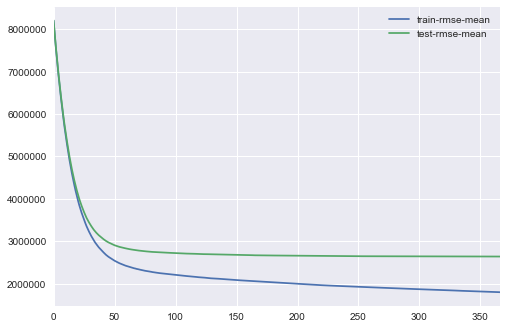

In [45]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [46]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

In [ ]:
#train_pca

In [47]:
y_predict = model.predict(dtest)

ValueError: feature_names mismatch: ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area', 'area_m', 'raion_popul', 'children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'office_raion', 'radiation_raion', 'full_all', 'male_f', 'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_male', '0_6_female', '7_14_male', '7_14_female', '0_17_all', '0_17_male', '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male', '0_13_female', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_wood', 'build_count_frame', 'build_count_brick', 'build_count_monolith', 'build_count_panel', 'build_count_foam', 'build_count_slag', 'build_count_mix', 'raion_build_count_with_builddate_info', 'build_count_before_1920', 'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995', 'build_count_after_1995', 'ID_metro', 'metro_min_avto', 'metro_km_avto', 'metro_min_walk', 'metro_km_walk', 'kindergarten_km', 'school_km', 'park_km', 'industrial_km', 'water_treatment_km', 'cemetery_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 'ID_railroad_station_walk', 'railroad_station_avto_km', 'railroad_station_avto_min', 'ID_railroad_station_avto', 'public_transport_station_km', 'public_transport_station_min_walk', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'big_road1_km', 'ID_big_road1', 'big_road2_km', 'ID_big_road2', 'railroad_km', 'zd_vokzaly_avto_km', 'ID_railroad_terminal', 'bus_terminal_avto_km', 'ID_bus_terminal', 'oil_chemistry_km', 'nuclear_reactor_km', 'radiation_km', 'power_transmission_line_km', 'thermal_power_plant_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'swim_pool_km', 'ice_rink_km', 'stadium_km', 'basketball_km', 'hospice_morgue_km', 'detention_facility_km', 'public_healthcare_km', 'university_km', 'workplaces_km', 'shopping_centers_km', 'office_km', 'additional_education_km', 'preschool_km', 'big_church_km', 'church_synagogue_km', 'mosque_km', 'theater_km', 'museum_km', 'exhibition_km', 'catering_km', 'ecology', 'green_part_500', 'prom_part_500', 'office_count_500', 'office_sqm_500', 'trc_count_500', 'trc_sqm_500', 'cafe_count_500', 'cafe_count_500_na_price', 'cafe_count_500_price_500', 'cafe_count_500_price_1000', 'cafe_count_500_price_1500', 'cafe_count_500_price_2500', 'cafe_count_500_price_4000', 'big_church_count_500', 'church_count_500', 'leisure_count_500', 'sport_count_500', 'market_count_500', 'green_part_1000', 'prom_part_1000', 'office_count_1000', 'office_sqm_1000', 'trc_count_1000', 'trc_sqm_1000', 'cafe_count_1000', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000', 'cafe_count_1000_na_price', 'cafe_count_1000_price_500', 'cafe_count_1000_price_1000', 'cafe_count_1000_price_1500', 'cafe_count_1000_price_2500', 'cafe_count_1000_price_4000', 'cafe_count_1000_price_high', 'big_church_count_1000', 'church_count_1000', 'leisure_count_1000', 'sport_count_1000', 'market_count_1000', 'green_part_1500', 'prom_part_1500', 'office_count_1500', 'office_sqm_1500', 'trc_count_1500', 'trc_sqm_1500', 'cafe_count_1500', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500', 'cafe_count_1500_na_price', 'cafe_count_1500_price_500', 'cafe_count_1500_price_1000', 'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500', 'cafe_count_1500_price_4000', 'cafe_count_1500_price_high', 'big_church_count_1500', 'church_count_1500', 'leisure_count_1500', 'sport_count_1500', 'market_count_1500', 'green_part_2000', 'prom_part_2000', 'office_count_2000', 'office_sqm_2000', 'trc_count_2000', 'trc_sqm_2000', 'cafe_count_2000', 'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'cafe_count_2000_na_price', 'cafe_count_2000_price_500', 'cafe_count_2000_price_1000', 'cafe_count_2000_price_1500', 'cafe_count_2000_price_2500', 'cafe_count_2000_price_4000', 'cafe_count_2000_price_high', 'big_church_count_2000', 'church_count_2000', 'leisure_count_2000', 'sport_count_2000', 'market_count_2000', 'green_part_3000', 'prom_part_3000', 'office_count_3000', 'office_sqm_3000', 'trc_count_3000', 'trc_sqm_3000', 'cafe_count_3000', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg', 'cafe_avg_price_3000', 'cafe_count_3000_na_price', 'cafe_count_3000_price_500', 'cafe_count_3000_price_1000', 'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500', 'cafe_count_3000_price_4000', 'cafe_count_3000_price_high', 'big_church_count_3000', 'church_count_3000', 'mosque_count_3000', 'leisure_count_3000', 'sport_count_3000', 'market_count_3000', 'green_part_5000', 'prom_part_5000', 'office_count_5000', 'office_sqm_5000', 'trc_count_5000', 'trc_sqm_5000', 'cafe_count_5000', 'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000', 'cafe_count_5000_na_price', 'cafe_count_5000_price_500', 'cafe_count_5000_price_1000', 'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000', 'cafe_count_5000_price_high', 'big_church_count_5000', 'church_count_5000', 'mosque_count_5000', 'leisure_count_5000', 'sport_count_5000', 'market_count_5000'] ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion', 'children_school', 'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 'culture_objects_top_25', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'full_all', 'male_f', 'young_female', 'ekder_male', 'ekder_female', '0_6_male', '0_6_female', '7_14_male', '7_14_female', '0_17_all', '0_17_male', '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male', '0_13_female', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_wood', 'build_count_frame', 'build_count_brick', 'build_count_monolith', 'build_count_panel', 'build_count_foam', 'build_count_slag', 'build_count_mix', 'raion_build_count_with_builddate_info', 'build_count_before_1920', 'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995', 'build_count_after_1995', 'ID_metro', 'metro_min_avto', 'metro_km_avto', 'metro_min_walk', 'metro_km_walk', 'kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_treatment_km', 'cemetery_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 'ID_railroad_station_walk', 'railroad_station_avto_km', 'railroad_station_avto_min', 'ID_railroad_station_avto', 'public_transport_station_min_walk', 'water_km', 'water_1line', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'big_road1_km', 'ID_big_road1', 'big_road1_1line', 'big_road2_km', 'ID_big_road2', 'railroad_km', 'railroad_1line', 'zd_vokzaly_avto_km', 'bus_terminal_avto_km', 'ID_bus_terminal', 'oil_chemistry_km', 'nuclear_reactor_km', 'radiation_km', 'power_transmission_line_km', 'thermal_power_plant_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'ice_rink_km', 'stadium_km', 'basketball_km', 'hospice_morgue_km', 'detention_facility_km', 'public_healthcare_km', 'university_km', 'workplaces_km', 'shopping_centers_km', 'office_km', 'additional_education_km', 'preschool_km', 'big_church_km', 'church_synagogue_km', 'mosque_km', 'theater_km', 'museum_km', 'exhibition_km', 'catering_km', 'ecology', 'green_part_500', 'prom_part_500', 'office_count_500', 'office_sqm_500', 'trc_count_500', 'trc_sqm_500', 'cafe_count_500', 'cafe_count_500_na_price', 'cafe_count_500_price_500', 'cafe_count_500_price_1000', 'cafe_count_500_price_1500', 'cafe_count_500_price_2500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'big_church_count_500', 'church_count_500', 'mosque_count_500', 'leisure_count_500', 'sport_count_500', 'market_count_500', 'green_part_1000', 'prom_part_1000', 'office_count_1000', 'office_sqm_1000', 'trc_count_1000', 'trc_sqm_1000', 'cafe_count_1000', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_count_1000_na_price', 'cafe_count_1000_price_500', 'cafe_count_1000_price_1500', 'cafe_count_1000_price_2500', 'cafe_count_1000_price_4000', 'cafe_count_1000_price_high', 'big_church_count_1000', 'church_count_1000', 'mosque_count_1000', 'leisure_count_1000', 'sport_count_1000', 'market_count_1000', 'green_part_1500', 'prom_part_1500', 'office_count_1500', 'office_sqm_1500', 'trc_count_1500', 'trc_sqm_1500', 'cafe_count_1500', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500', 'cafe_count_1500_na_price', 'cafe_count_1500_price_500', 'cafe_count_1500_price_1000', 'cafe_count_1500_price_2500', 'cafe_count_1500_price_4000', 'cafe_count_1500_price_high', 'big_church_count_1500', 'church_count_1500', 'mosque_count_1500', 'leisure_count_1500', 'sport_count_1500', 'market_count_1500', 'green_part_2000', 'prom_part_2000', 'office_count_2000', 'office_sqm_2000', 'trc_count_2000', 'trc_sqm_2000', 'cafe_count_2000', 'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'cafe_count_2000_na_price', 'cafe_count_2000_price_500', 'cafe_count_2000_price_1000', 'cafe_count_2000_price_1500', 'cafe_count_2000_price_4000', 'cafe_count_2000_price_high', 'big_church_count_2000', 'church_count_2000', 'mosque_count_2000', 'leisure_count_2000', 'sport_count_2000', 'market_count_2000', 'green_part_3000', 'prom_part_3000', 'office_count_3000', 'office_sqm_3000', 'trc_count_3000', 'trc_sqm_3000', 'cafe_count_3000', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg', 'cafe_avg_price_3000', 'cafe_count_3000_na_price', 'cafe_count_3000_price_500', 'cafe_count_3000_price_1000', 'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500', 'cafe_count_3000_price_high', 'big_church_count_3000', 'church_count_3000', 'mosque_count_3000', 'leisure_count_3000', 'sport_count_3000', 'market_count_3000', 'green_part_5000', 'prom_part_5000', 'office_count_5000', 'office_sqm_5000', 'trc_count_5000', 'trc_sqm_5000', 'cafe_count_5000', 'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000', 'cafe_count_5000_na_price', 'cafe_count_5000_price_500', 'cafe_count_5000_price_1000', 'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000', 'cafe_count_5000_price_high', 'big_church_count_5000', 'church_count_5000', 'mosque_count_5000', 'leisure_count_5000', 'sport_count_5000', 'market_count_5000']
expected public_transport_station_km, office_raion, cafe_count_2000_price_2500, work_male, swim_pool_km, cafe_count_3000_price_4000, cafe_count_1500_price_1500, cafe_count_1000_price_1000, children_preschool, ts_km, young_male, ID_railroad_terminal, work_female, work_all, young_all, cafe_avg_price_1000, preschool_quota, ekder_all, female_f in input data
training data did not have the following fields: detention_facility_raion, indust_part, incineration_raion, green_zone_km, culture_objects_top_25, oil_chemistry_raion, water_1line, mosque_count_1000, mosque_count_2000, railroad_terminal_raion, nuclear_reactor_raion, cafe_count_500_price_high, mosque_count_500, big_market_raion, railroad_1line, big_road1_1line, green_zone_part, thermal_power_plant_raion, mosque_count_1500

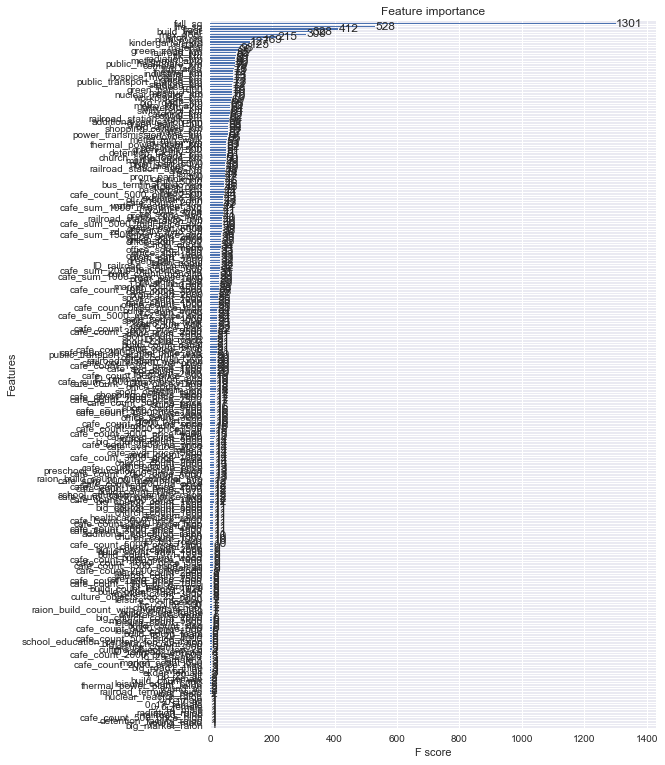

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model,  height=0.5, ax=ax)

In [26]:
ss = pd.read_csv('sample_submission.csv')

In [ ]:
ss.head()

In [27]:
output = pd.DataFrame({'id': ss.id, 'price_doc': y_predict})
output.head()

,id,price_doc
0,30474,5591389.5
1,30475,8407146.0
2,30476,5469494.5
3,30477,5669749.0
4,30478,5231309.0


In [28]:
output.to_csv('xgbSub4.csv', index=False) #0.31727 score on Kaggle